In [1]:
import os
import sys
sys.path.insert(0,os.path.abspath('/notebooks/4901_revisit_cdtrans'))


# 1 Run Reader

In [2]:
## 1.2 读取 mean 数据


from dataclasses import asdict
import string
from openpyxl import Workbook
import pandas as pd
import wandb
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Alignment

# 初始化Wandb API
api = wandb.Api()

def convert_dict(dictionary):
    converted_dict = {}
    for key, value in dictionary.items():
        converted_dict[f"config.{key}"] = value
    return converted_dict

# 查询特定配置的运行
project_name = "ForecastBase"  # 替换为你的项目名称

all_data = {}
runs = api.runs(path="ForecastBase")


## 2.1 Ablation Parrellel graph

In [18]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {96,168,336,720}
selected_window = 336
model = "CiDPG"
all_data = [['dataset_type', 'pred_len', 'patch_len', 'stride', 'start_d_model', 'end_d_model', 'best_test_mse', 'best_test_mae']]
from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if run.state == "finished" and run.config['model_type'] == model and run.config['windows'] == selected_window and run.config['pred_len']  in selected_pred_lens:
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                data = (run.config['dataset_type'], run.config['pred_len'], run.config['patch_len'],run.config['stride'], run.config['start_d_model'],run.config['end_d_model'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                all_data.append(data)
            except:
                pass


  0%|          | 0/9394 [00:00<?, ?it/s]

In [9]:
# index = pd.MultiIndex.from_arrays(all_data, names=['dataset_type', 'pred_len', 'patch_len', 'stride', 'start_d_model', 'end_d_model', 'best_test_mse', 'best_test_mae'])
all_data[0] = ['dataset_type', 'pred_len', 'patch_len', 'stride', 'start_d_model', 'end_d_model', 'best_test_mse', 'best_test_mae'],

In [10]:
del all_data[0]

In [21]:
df = pd.DataFrame(all_data, columns=['dataset_type', 'pred_len', 'patch_len', 'stride', 'start_d_model', 'end_d_model', 'best_test_mse', 'best_test_mae'])
# df = df.set_index(['dataset_type', 'pred_len', 'patch_len', 'stride', 'start_d_model', 'end_d_model'])
# df.set_index(['dataset_type', 'pred_len'], inplace=True)
# df = df.sort_index()
df

,dataset_type,pred_len,patch_len,stride,start_d_model,end_d_model,best_test_mse,best_test_mae
0,ETTh1,96,32,24,64,256,0.387610,0.439258
1,Weather,96,32,24,64,256,0.173931,0.207295
2,Electricity,96,32,24,64,256,0.149601,0.248913
3,ETTh1,96,32,24,64,256,0.386901,0.440413
4,Weather,96,32,24,64,256,0.173807,0.208695
...,...,...,...,...,...,...,...,...
2493,Electricity,336,192,128,512,512,0.162315,0.265423
2494,Traffic,720,32,24,128,128,0.566913,0.383138
2495,Electricity,336,192,128,512,512,0.162677,0.265744
2496,Electricity,336,192,128,512,512,0.163081,0.265916


In [27]:
# 给定 dataset_type 和 pred_len 过滤数据
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

dataset_type = 'ETTm1'
pred_len = 96
import plotly.express as px


# 创建 DataFrame
df = pd.DataFrame(all_data, columns=['dataset_type', 'pred_len', 'patch_len', 'stride', 'start_d_model', 'end_d_model', 'best_test_mse', 'best_test_mae'])
filtered_df = df[(df['dataset_type'] == dataset_type) & (df['pred_len'] == pred_len)].reset_index(drop=True)

# 使用 Plotly 绘制平行坐标图
fig = px.parallel_coordinates(
    filtered_df,
    dimensions=['patch_len', 'stride', 'start_d_model', 'end_d_model', 'best_test_mse', 'best_test_mae'],
    color='best_test_mse',
    color_continuous_scale=px.colors.sequential.Viridis,
    labels={
        'patch_len': 'Patch Length',
        'stride': 'Stride',
        'start_d_model': 'Start D Model',
        'end_d_model': 'End D Model',
        'best_test_mse': 'Best Test MSE',
        'best_test_mae': 'Best Test MAE'
    },
    title=f'Parallel Coordinates for {dataset_type} with pred_len {pred_len}'
)

# 导出为 HTML 文件
output_file = './parallel_coordinates.html'
fig.write_html(output_file)

# 提示用户导出成功
output_file


'./parallel_coordinates.html'

In [29]:
import plotly.graph_objects as go

filtered_df = df[(df['dataset_type'] == dataset_type) & (df['pred_len'] == pred_len)].reset_index(drop=True)

# 创建 Plotly 图表对象
fig = go.Figure(data=go.Parcoords(
    line=dict(color=filtered_df['best_test_mse'],
              colorscale='Viridis',
              showscale=True),
    dimensions=[
        dict(label='Patch Length', values=filtered_df['patch_len'], tickformat=".0f"),
        dict(label='Stride', values=filtered_df['stride'], tickformat=".0f"),
        dict(label='Start D Model', values=filtered_df['start_d_model'], tickformat=".0f"),
        dict(label='End D Model', values=filtered_df['end_d_model'], tickformat=".0f"),
        dict(label='Best Test MSE', values=filtered_df['best_test_mse']),
        dict(label='Best Test MAE', values=filtered_df['best_test_mae'])
    ]
))

# 设置图表的标题
fig.update_layout(
    title=f'Parallel Coordinates for {dataset_type} with pred_len {pred_len}',
    plot_bgcolor='white'
)

# 导出为 HTML 文件
output_file = './parallel_coordinates_with_hover.html'
fig.write_html(output_file)

# 提示用户导出成功
output_file


'./parallel_coordinates_with_hover.html'

In [30]:
fig

In [ ]:
from pandas.plotting import parallel_coordinates


In [31]:
!pip install holoviews bokeh


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 6.3 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 6.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 6.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.3/260.3 kB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 8.2 MB/s eta 0:00:00


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
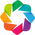

AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

In [33]:
import holoviews as hv
from bokeh.io import output_file, save, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Viridis256
from bokeh.plotting import figure
from bokeh.transform import linear_cmap

hv.extension('bokeh')

filtered_df = df[(df['dataset_type'] == dataset_type) & (df['pred_len'] == pred_len)].reset_index(drop=True)

# 将数据转换为 Bokeh 的 ColumnDataSource
source = ColumnDataSource(filtered_df)

# 创建 Bokeh 图形对象
p = figure(
    title=f'Parallel Coordinates for {dataset_type} with pred_len {pred_len}',
    plot_width=900, plot_height=400,
    tools="pan,wheel_zoom,box_zoom,reset,save"
)

# 映射颜色
color_mapper = linear_cmap(field_name='best_test_mse', palette=Viridis256, low=min(filtered_df['best_test_mse']), high=max(filtered_df['best_test_mse']))

# 平行坐标图的轴名称和数据列
dimensions = ['patch_len', 'stride', 'start_d_model', 'end_d_model', 'best_test_mse', 'best_test_mae']

# 绘制平行坐标图的每一条线
for i in range(len(filtered_df)):
    p.line(
        x=dimensions, 
        y=[filtered_df.loc[i, dim] for dim in dimensions],
        color=color_mapper['transform'](filtered_df.loc[i, 'best_test_mse']),
        line_width=2,
        alpha=0.6,
        legend_label=str(filtered_df.loc[i, 'best_test_mse'])
    )

# 添加 HoverTool 工具
hover = HoverTool(tooltips=[(dim, f"@{dim}") for dim in dimensions])
p.add_tools(hover)

# 导出为 HTML 文件
output_file("./bokeh_parallel_coordinates.html")
save(p)


In [34]:
# 选择需要绘制的列
df_filtered = df[['patch_len', 'stride', 'start_d_model', 'end_d_model', 'best_test_mse', 'best_test_mae']]

# 使用 wandb.plot.ParallelCoordinatesPlot 绘制平行坐标图
parallel_coords_plot = wandb.plot.parallel_coordinates(
    dataframe=df_filtered,
    class_column='best_test_mse',  # 用于颜色映射的列
    columns=['patch_len', 'stride', 'start_d_model', 'end_d_model', 'best_test_mse', 'best_test_mae']
)

# 将平行坐标图记录到 wandb
wandb.log({"Parallel Coordinates": parallel_coords_plot})

# 结束 wandb 运行
wandb.finish()


AttributeError: module 'wandb.plot' has no attribute 'parallel_coordinates'

# 3 Results

## 3.1 Main

In [39]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {96,168,336,720}
selected_window = 336
model_list = ["CiDPG", "CATS", "iTransformer", "Crossformer", "PatchTST", "SCINet", "Informer", "TSMixer", "DLinear"]
data_sets = ["ETTm1","ETTm2","ETTh1","ETTh2","ExchangeRate","Weather","Traffic","Electricity"]
# all_data = [['dataset_type', 'pred_len', 'patch_len', 'stride', 'start_d_model', 'end_d_model', 'best_test_mse', 'best_test_mae']]
# all_data = [['dataset_type', 'pred_len', 'best_test_mse', 'best_test_mae']]
all_data = {}
seeds = [1,2,3,4,5]

from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if run.state == "finished" and run.config['model_type'] in model_list and run.config['windows'] == selected_window and run.config['pred_len']  in selected_pred_lens:
            
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                key = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.config['seed'])
                # data = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                if key in all_data:
                    if float(run.summary['best_test_mse']) < all_data[key][0]:
                        all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
                else:
                    all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
            except:
                pass


  0%|          | 0/10173 [00:00<?, ?it/s]

In [40]:
all_data_list = [k+v for k,v in all_data.items()]

In [41]:
df = pd.DataFrame(all_data_list, columns=['model_type', 'dataset_type', 'pred_len', 'seed', 'MSE', 'MAE'])
df.set_index(['model_type', 'dataset_type', 'pred_len', 'seed'], inplace=True)
df = df.sort_index()
df

MSE       MAE
model_type   dataset_type pred_len seed                    
CATS         ETTh1        96       1     0.355033  0.415283
                                   2     0.368822  0.428434
                                   3     0.351427  0.411515
                                   4     0.353841  0.413040
                                   5     0.353013  0.413482
...                                           ...       ...
iTransformer Weather      720      1     0.317147  0.304150
                                   2     0.311553  0.301461
                                   3     0.315770  0.304472
                                   4     0.311006  0.301199
                                   5     0.313840  0.301960

[1423 rows x 2 columns]

In [42]:
mean_df = df.groupby(["model_type", "dataset_type", "pred_len"])[["MSE", "MAE"]].mean().reset_index()
mean_df.set_index(['model_type', 'dataset_type', 'pred_len'], inplace=True)
mean_df = mean_df.sort_index()
mean_df=  mean_df.stack().unstack(0).unstack(2)
mean_df.to_excel('./baseline_result.xlsx')

In [44]:

def style_rule(best, second_best):
    if best:
        return 'font-weight: bold'
    elif second_best:
        return 'text-decoration: underline'
    else:
        return ''
with pd.ExcelWriter('./baseline_result.xlsx') as writer:
    def highlight_best(norm):
        styles = []
        # import pdb;pdb.set_trace()
        # for model in norm.index.levels[0]:
        
        
        all_is_best = []
        all_is_second_best = []
        # find the best metrics
        for metric in norm.index.levels[1]:
            is_best = []
            is_second_best = []
            best, second_best = sorted(norm[:, metric])[0:2]
            
            for md, v in  norm[:, metric].items():
                is_best.append(v == best)
                is_second_best.append(v==second_best)
            
            all_is_best.append(is_best)
            all_is_second_best.append(is_second_best)
        
        all_is_best = [b for a in zip(*all_is_best) for b in a]
        all_is_second_best =[b for a in zip(*all_is_second_best) for b in a]
        
        # for model in norm.index:
        #     is_best.append(norm.loc[model] == best)
        #     is_second_best.append(norm.loc[model] == second_best)
        styles.extend( [style_rule(best,second_best) for best, second_best in zip(all_is_best,all_is_second_best)  ] )        
        return styles
        # return ['color: black; font-weight: bold' if v else 'color: darkgreen;  font-weight: bold' if sb else '' for v, sb in zip(is_best, is_second_best)]
        # return ['color: black; font-weight: bold' if v else 'color: darkgreen;  font-weight: bold' if sb else '' for v, sb in zip(is_best, is_second_best)]

    # 对 DataFrame 的每一行应用 highlight_best 函数
    styled_df = mean_df.style.apply(highlight_best, axis=1)

    # 将样式化的 DataFrame 写入 Excel 文件
    styled_df.to_excel(writer, engine='openpyxl')


In [19]:
run.config

{'lr': 0.0003,
 'device': 'cuda:5',
 'epochs': 100,
 'horizon': 1,
 'windows': 336,
 'patience': 5,
 'pred_len': 168,
 'save_dir': './results',
 'data_path': './data',
 'optm_type': 'Adam',
 'val_ratio': 0.2,
 'batch_size': 32,
 'individual': False,
 'model_type': 'DLinear',
 'num_worker': 5,
 'scaler_type': 'StandardScaler',
 'train_ratio': 0.7,
 'dataset_type': 'Weather',
 'invtrans_loss': False,
 'max_grad_norm': 5,
 'loss_func_type': 'mse',
 'l2_weight_decay': 0.0005,
 'experiment_label': ''}

## 3.2 Main Parameter Sensitivity

In [8]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {96,168,336,720}
selected_window = 336
model_list = ["CiDPG"]
data_sets = ["ETTm1","ETTm2","ETTh1","ETTh2","ExchangeRate","Weather","Traffic","Electricity"]
config_sets = ["start_d_model", "end_d_model", "patch_len", "stride"]
config_mark = '-'.join(config_sets)
all_data = {}
seeds = [1,2,3,4,5]

from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if run.state == "finished" and run.config['model_type'] in model_list and run.config['windows'] == selected_window and run.config['pred_len']  in selected_pred_lens:
            
            
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                key = (run.config['dataset_type'], run.config['pred_len'],'-'.join([str(run.config['start_d_model']), str(run.config['end_d_model']), "P"+str(run.config['patch_len']), "S"+str(run.config['stride'])]),  run.config['seed'])
                # data = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                if key in all_data:
                    if float(run.summary['best_test_mse']) < all_data[key][0]:
                        all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
                else:
                    all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
            except:
                pass


  0%|          | 0/9356 [00:00<?, ?it/s]

In [9]:
len(all_data)

4691

In [10]:
all_data_list = [k+v for k,v in all_data.items()]
# cols = [ 'dataset_type', 'pred_len'] + config_sets+[ 'seed', 'MSE', 'MAE']
df = pd.DataFrame(all_data_list, columns=[config_mark, 'dataset_type', 'pred_len', 'seed', 'MSE', 'MAE'])
df.set_index([config_mark, 'dataset_type', 'pred_len', 'seed'], inplace=True)
df = df.sort_index()
df

MSE  \
start_d_model-end_d_model-patch_len-stride dataset_type pred_len           seed             
ETTh1                                      96           128-1024-P128-S128 1     0.391501   
                                                                           2     0.391342   
                                                                           3     0.398448   
                                                                           4     0.398024   
                                                                           5     0.395058   
...                                                                                   ...   
Weather                                    720          64-256-P64-S48     1     0.317041   
                                                                           2     0.316517   
                                                                           3     0.317349   
                                                                           4     0.319011   
                                                                           5     0.321640   

                                                                                      MAE  
start_d_model-end_d_model-patch_len-stride dataset_type pred_len           seed            
ETTh1                                      96           128-1024-P128-S128 1     0.452150  
                                                                           2     0.453092  
                                                                           3     0.455538  
                                                                           4     0.455179  
                                                                           5     0.454390  
...                                                                                   ...  
Weather                                    720          64-256-P64-S48     1     0.303685  
                                                                           2     0.303727  
                                                                           3     0.304180  
                                                                           4     0.305956  
                                                                           5     0.308511  

[4691 rows x 2 columns]

In [11]:
mean_df = df.groupby( [config_mark, 'dataset_type', 'pred_len'])[["MSE", "MAE"]].mean().reset_index()
mean_df.set_index([ config_mark,'dataset_type', 'pred_len'] , inplace=True)
mean_df = mean_df.sort_index()
# mean_df = mean_df.stack().unstack(2).unstack(2)
mean_df = mean_df.stack().unstack(2)
mean_df.to_excel('./ablation_main.xlsx')
mean_df
# mean_df=  mean_df.stack().unstack(0).unstack(2)

pred_len                                                     128-1024-P128-S128  \
start_d_model-end_d_model-patch_len-stride dataset_type                           
ETTh1                                      96           MSE            0.394874   
                                                        MAE            0.454070   
                                           168          MSE            0.417846   
                                                        MAE            0.470691   
                                           336          MSE            0.458618   
...                                                                         ...   
Weather                                    168          MAE                 NaN   
                                           336          MSE                 NaN   
                                                        MAE                 NaN   
                                           720          MSE                 NaN   
                                                        MAE                 NaN   

pred_len                                                     128-1024-P168-S128  \
start_d_model-end_d_model-patch_len-stride dataset_type                           
ETTh1                                      96           MSE            0.385137   
                                                        MAE            0.443305   
                                           168          MSE            0.407831   
                                                        MAE            0.463489   
                                           336          MSE            0.452450   
...                                                                         ...   
Weather                                    168          MAE            0.229859   
                                           336          MSE            0.261492   
                                                        MAE            0.271185   
                                           720          MSE            0.316524   
                                                        MAE            0.305076   

pred_len                                                     128-1024-P192-S192  \
start_d_model-end_d_model-patch_len-stride dataset_type                           
ETTh1                                      96           MSE            0.402767   
                                                        MAE            0.461015   
                                           168          MSE            0.435642   
                                                        MAE            0.483332   
                                           336          MSE            0.478483   
...                                                                         ...   
Weather                                    168          MAE            0.245524   
                                           336          MSE            0.276034   
                                                        MAE            0.279938   
                                           720          MSE            0.324490   
                                                        MAE            0.309951   

pred_len                                                     128-1024-P256-S128  \
start_d_model-end_d_model-patch_len-stride dataset_type                           
ETTh1                                      96           MSE                 NaN   
                                                        MAE                 NaN   
                                           168          MSE                 NaN   
                                                        MAE                 NaN   
                                           336          MSE                 NaN   
...                                                                         ...   
Weather                                    168          MAE            0.234632   
             

In [83]:
# round results
# df.round(4)


# 假设 df 是你的 DataFrame
# 创建一个 ExcelWriter 对象

def style_rule(best, second_best):
    if best:
        return 'font-weight: bold'
    elif second_best:
        return 'text-decoration: underline'
    else:
        return ''
a  = None
with pd.ExcelWriter('./ablation_main.xlsx') as writer:
    # 定义一个函数，用于找到最好和第二好的结果，并将它们设置为黑体
    def highlight_best(norm):
        # 找到 mae 和 mse 的最好和第二好的结果
        styles = []
        # import pdb;pdb.set_trace()
        # for model in norm.index.levels[0]:
        best = norm.min()
        second_best = sorted(norm)[1]
        
        is_best = []
        is_second_best = []
        
        for model in norm.index:
            is_best.append(norm.loc[model] == best)
            is_second_best.append(norm.loc[model] == second_best)
            
        styles.extend( [style_rule(best,second_best) for best, second_best in zip(is_best,is_second_best)  ] )        
        return styles
        # return ['color: black; font-weight: bold' if v else 'color: darkgreen;  font-weight: bold' if sb else '' for v, sb in zip(is_best, is_second_best)]
        # return ['color: black; font-weight: bold' if v else 'color: darkgreen;  font-weight: bold' if sb else '' for v, sb in zip(is_best, is_second_best)]

    # 对 DataFrame 的每一行应用 highlight_best 函数
    styled_df = mean_df.style.apply(highlight_best, axis=1)

    # 将样式化的 DataFrame 写入 Excel 文件
    styled_df.to_excel(writer, engine='openpyxl')


In [85]:
all_data_list = [k+v for k,v in all_data.items()]
# cols = [ 'dataset_type', 'pred_len'] + config_sets+[ 'seed', 'MSE', 'MAE']
df = pd.DataFrame(all_data_list, columns=[config_mark, 'dataset_type', 'pred_len', 'seed', 'MSE', 'MAE'])
df.set_index([config_mark, 'dataset_type', 'pred_len', 'seed'], inplace=True)
df = df.sort_index()
mean_df = df.groupby( [config_mark, 'dataset_type', 'pred_len'])[["MSE", "MAE"]].mean().reset_index()
mean_df.set_index([ config_mark,'dataset_type', 'pred_len'] , inplace=True)
mean_df = mean_df.sort_index()
# mean_df = mean_df.stack().unstack(2).unstack(2)
mean_df = mean_df.stack().unstack(2)
mean_df.to_excel('./traffic_ablation_main.xlsx')
mean_df
# mean_df=  mean_df.stack().unstack(0).unstack(2)

pred_len                                                     128-1024-P128-S128  \
start_d_model-end_d_model-patch_len-stride dataset_type                           
ETTh1                                      96           MSE            0.394874   
                                                        MAE            0.454070   
                                           168          MSE            0.417846   
                                                        MAE            0.470691   
                                           336          MSE            0.458618   
...                                                                         ...   
Weather                                    168          MAE                 NaN   
                                           336          MSE                 NaN   
                                                        MAE                 NaN   
                                           720          MSE                 NaN   
                                                        MAE                 NaN   

pred_len                                                     128-1024-P168-S128  \
start_d_model-end_d_model-patch_len-stride dataset_type                           
ETTh1                                      96           MSE            0.385137   
                                                        MAE            0.443305   
                                           168          MSE            0.407831   
                                                        MAE            0.463489   
                                           336          MSE            0.452450   
...                                                                         ...   
Weather                                    168          MAE            0.229859   
                                           336          MSE            0.261492   
                                                        MAE            0.271185   
                                           720          MSE            0.316524   
                                                        MAE            0.305076   

pred_len                                                     128-1024-P192-S192  \
start_d_model-end_d_model-patch_len-stride dataset_type                           
ETTh1                                      96           MSE            0.402767   
                                                        MAE            0.461015   
                                           168          MSE            0.435642   
                                                        MAE            0.483332   
                                           336          MSE            0.478483   
...                                                                         ...   
Weather                                    168          MAE            0.245524   
                                           336          MSE            0.276034   
                                                        MAE            0.279938   
                                           720          MSE            0.324490   
                                                        MAE            0.309951   

pred_len                                                     128-1024-P256-S128  \
start_d_model-end_d_model-patch_len-stride dataset_type                           
ETTh1                                      96           MSE                 NaN   
                                                        MAE                 NaN   
                                           168          MSE                 NaN   
                                                        MAE                 NaN   
                                           336          MSE                 NaN   
...                                                                         ...   
Weather                                    168          MAE            0.234632   
             

In [86]:
# round results
# df.round(4)


# 假设 df 是你的 DataFrame
# 创建一个 ExcelWriter 对象

def style_rule(best, second_best):
    if best:
        return 'font-weight: bold'
    elif second_best:
        return 'text-decoration: underline'
    else:
        return ''
a  = None
with pd.ExcelWriter('./traffic_ablation_main.xlsx') as writer:
    # 定义一个函数，用于找到最好和第二好的结果，并将它们设置为黑体
    def highlight_best(norm):
        # 找到 mae 和 mse 的最好和第二好的结果
        styles = []
        # import pdb;pdb.set_trace()
        # for model in norm.index.levels[0]:
        best = norm.min()
        second_best = sorted(norm)[1]
        
        is_best = []
        is_second_best = []
        
        for model in norm.index:
            is_best.append(norm.loc[model] == best)
            is_second_best.append(norm.loc[model] == second_best)
            
        styles.extend( [style_rule(best,second_best) for best, second_best in zip(is_best,is_second_best)  ] )        
        return styles
        # return ['color: black; font-weight: bold' if v else 'color: darkgreen;  font-weight: bold' if sb else '' for v, sb in zip(is_best, is_second_best)]
        # return ['color: black; font-weight: bold' if v else 'color: darkgreen;  font-weight: bold' if sb else '' for v, sb in zip(is_best, is_second_best)]

    # 对 DataFrame 的每一行应用 highlight_best 函数
    styled_df = mean_df.style.apply(highlight_best, axis=1)

    # 将样式化的 DataFrame 写入 Excel 文件
    styled_df.to_excel(writer, engine='openpyxl')


In [17]:
all_data

{('iTransformer', 'ExchangeRate', 720, 1): (0.9405511617660522,
  0.8368247151374817),
 ('iTransformer', 'ExchangeRate', 720, 2): (1.331333875656128,
  1.0272618532180786),
 ('iTransformer', 'ExchangeRate', 720, 3): (1.9208383560180664,
  1.2516556978225708),
 ('iTransformer', 'ExchangeRate', 720, 4): (1.2372666597366333,
  0.9568985104560852),
 ('iTransformer', 'ExchangeRate', 720, 5): (0.8423184752464294,
  0.7750474810600281),
 ('iTransformer', 'ETTh2', 96, 1): (0.11683269590139388, 0.24305640161037445),
 ('iTransformer', 'ETTh1', 96, 1): (0.38179218769073486, 0.43398353457450867),
 ('iTransformer', 'ETTm1', 96, 1): (0.3084787428379059, 0.37438833713531494),
 ('iTransformer', 'ETTh2', 96, 2): (0.12885339558124542, 0.25593048334121704),
 ('iTransformer', 'ETTh1', 96, 2): (0.3719258606433869, 0.42612940073013306),
 ('iTransformer', 'ETTh2', 96, 3): (0.11861856281757356, 0.24528388679027557),
 ('iTransformer', 'ETTh2', 96, 4): (0.121360145509243, 0.24611766636371613),
 ('iTransformer',

## 3.3 Traffic Parameter Sensitivity

In [28]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {3,6,12}
selected_window = 96
model_list = ["CiDPG"]
data_sets = ["PEMS_BAY","METR_LA","PEMS04","PEMS07"]
config_sets = ["start_d_model", "end_d_model", "patch_len", "stride"]
config_mark = '-'.join(config_sets)
all_data = {}
seeds = [1,2,3,4,5]



from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if run.state == "finished" and run.config['model_type'] in model_list and run.config['windows'] == selected_window and run.config['pred_len']  in selected_pred_lens:
            
            
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                key = (run.config['dataset_type'], run.config['pred_len'],'-'.join([str(run.config['start_d_model']), str(run.config['end_d_model']), "P"+str(run.config['patch_len']), "S"+str(run.config['stride'])]),  run.config['seed'])
                # data = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                if key in all_data:
                    if float(run.summary['best_test_mse']) < all_data[key][0]:
                        all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
                else:
                    all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
            except:
                pass


  0%|          | 0/11772 [00:00<?, ?it/s]

In [29]:
all_data_list = [k+v for k,v in all_data.items()]
# cols = [ 'dataset_type', 'pred_len'] + config_sets+[ 'seed', 'MSE', 'MAE']
df = pd.DataFrame(all_data_list, columns=[config_mark, 'dataset_type', 'pred_len', 'seed', 'MSE', 'MAE'])
df.set_index([config_mark, 'dataset_type', 'pred_len', 'seed'], inplace=True)
df = df.sort_index()
mean_df = df.groupby( [config_mark, 'dataset_type', 'pred_len'])[["MSE", "MAE"]].mean().reset_index()
mean_df.set_index([ config_mark,'dataset_type', 'pred_len'] , inplace=True)
mean_df = mean_df.sort_index()
# mean_df = mean_df.stack().unstack(2).unstack(2)
mean_df = mean_df.stack().unstack(2)
mean_df.to_excel('./traffic_ablation_main.xlsx')
mean_df
# mean_df=  mean_df.stack().unstack(0).unstack(2)

pred_len                                                     128-1024-P24-S12  \
start_d_model-end_d_model-patch_len-stride dataset_type                         
METR_LA                                    3            MSE               NaN   
                                                        MAE               NaN   
                                           6            MSE               NaN   
                                                        MAE               NaN   
                                           12           MSE          0.400928   
                                                        MAE          0.303255   
PEMS03                                     3            MSE               NaN   
                                                        MAE               NaN   
                                           6            MSE               NaN   
                                                        MAE               NaN   
                                           12           MSE               NaN   
                                                        MAE               NaN   
PEMS04                                     3            MSE               NaN   
                                                        MAE               NaN   
                                           6            MSE               NaN   
                                                        MAE               NaN   
                                           12           MSE               NaN   
                                                        MAE               NaN   
PEMS07                                     3            MSE               NaN   
                                                        MAE               NaN   
                                           6            MSE               NaN   
                                                        MAE               NaN   
                                           12           MSE               NaN   
                                                        MAE               NaN   
PEMS08                                     3            MSE               NaN   
                                                        MAE               NaN   
                                           6            MSE               NaN   
                                                        MAE               NaN   
                                           12           MSE               NaN   
                                                        MAE               NaN   
PEMS_BAY                                   3            MSE               NaN   
                                                        MAE               NaN   
                                           6            MSE               NaN   
                                                        MAE               NaN   
                                           12           MSE               NaN   
                                                        MAE               NaN   

pred_len                                                     128-1024-P48-S12  \
start_d_model-end_d_model-patch_len-stride dataset_type                         
METR_LA                                    3            MSE          0.187719   
                                                        MAE          0.190558   
                                           6            MSE          0.267485   
                                                        MAE          0.235218   
                                           12           MSE          0.402795   
                                                        MAE          0.301279   
PEMS03                                     3            MSE               NaN   
                                                        MAE               NaN   
                                           6            MSE               NaN   
                              

In [30]:
# round results
# df.round(4)


# 假设 df 是你的 DataFrame
# 创建一个 ExcelWriter 对象

def style_rule(best, second_best):
    if best:
        return 'font-weight: bold'
    elif second_best:
        return 'text-decoration: underline'
    else:
        return ''
a  = None
with pd.ExcelWriter('./traffic_ablation_main.xlsx') as writer:
    # 定义一个函数，用于找到最好和第二好的结果，并将它们设置为黑体
    def highlight_best(norm):
        # 找到 mae 和 mse 的最好和第二好的结果
        styles = []
        # import pdb;pdb.set_trace()
        # for model in norm.index.levels[0]:
        best = norm.min()
        second_best = sorted(norm)[1]
        
        is_best = []
        is_second_best = []
        
        for model in norm.index:
            is_best.append(norm.loc[model] == best)
            is_second_best.append(norm.loc[model] == second_best)
            
        styles.extend( [style_rule(best,second_best) for best, second_best in zip(is_best,is_second_best)  ] )        
        return styles
        # return ['color: black; font-weight: bold' if v else 'color: darkgreen;  font-weight: bold' if sb else '' for v, sb in zip(is_best, is_second_best)]
        # return ['color: black; font-weight: bold' if v else 'color: darkgreen;  font-weight: bold' if sb else '' for v, sb in zip(is_best, is_second_best)]

    # 对 DataFrame 的每一行应用 highlight_best 函数
    styled_df = mean_df.style.apply(highlight_best, axis=1)

    # 将样式化的 DataFrame 写入 Excel 文件
    styled_df.to_excel(writer, engine='openpyxl')


In [9]:
df

MAE     SMAPE      RMSE
model_type   dataset_type pred_len seed                              
CATS         METR_LA      3        1     0.197623  0.393662  0.438954
                                   2     0.195697  0.426024  0.437863
                                   3     0.198159  0.392122  0.441051
                                   4     0.199062  0.393321  0.440639
                                   5     0.199555  0.403565  0.439856
...                                           ...       ...       ...
iTransformer PEMS_BAY     12       1     0.273849  0.565113  0.590639
                                   2     0.275527  0.563598  0.594783
                                   3     0.275896  0.571818  0.595297
                                   4     0.274191  0.566153  0.591263
                                   5     0.273500  0.559154  0.595854

[772 rows x 3 columns]

## 3.4 traffic Main



In [24]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {3,6,12}
selected_window = 96
model_list = ["CiDPG", "CATS", "iTransformer", "Crossformer", "PatchTST", "SCINet", "Informer", "TSMixer", "DLinear"]
data_sets = ["PEMS04","PEMS07","PEMS08","PEMS_BAY"]
all_data = {}
seeds = [1,2,3,4,5]

def pick_main(run):
    if run.state == "finished" and run.config['dataset_type'] in data_sets and run.config['model_type'] in model_list and run.config['windows'] == selected_window and run.config['pred_len']  in selected_pred_lens:
        if run.config['model_type'] == "CiDPG":
            if run.config['start_d_model'] == 128 and run.config['end_d_model'] == 512 and run.config['patch_len']==96 and run.config['stride']==48:
                return True
        else:
            return True                
    
    return False

from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if pick_main(run):
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                key = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.config['seed'])
                # data = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                if key in all_data:
                    if float(run.summary['best_test_rmse']) < all_data[key][2]:
                        all_data[key] = (run.summary['best_test_mae'], run.summary['best_test_smape'], run.summary['best_test_rmse'])
                else:
                    all_data[key] =  (run.summary['best_test_mae'], run.summary['best_test_smape'], run.summary['best_test_rmse'])
            except:
                pass


  0%|          | 0/11772 [00:00<?, ?it/s]

In [25]:
# all_data_list = [k+v for k,v in all_data.items()]
# df = pd.DataFrame(all_data_list, columns=['model_type', 'dataset_type', 'pred_len', 'seed', 'MAE', 'SMAPE', 'RMSE'])
# df.set_index(['model_type', 'dataset_type', 'pred_len', 'seed'], inplace=True)
# df = df.sort_index()
# # df.loc['CiDPG', :]
# # mean_df = df.groupby(["model_type", "dataset_type", "pred_len"])[["MAE", "SMAPE", "RMSE"]].mean().reset_index()
# # mean_df

In [26]:
all_data_list = [k+v for k,v in all_data.items()]
df = pd.DataFrame(all_data_list, columns=['model_type', 'dataset_type', 'pred_len', 'seed', 'MAE', 'SMAPE', 'RMSE'])
df.set_index(['model_type', 'dataset_type', 'pred_len', 'seed'], inplace=True)
df = df.sort_index()
mean_df = df.groupby(["model_type", "dataset_type", "pred_len"])[["MAE", "SMAPE", "RMSE"]].mean().reset_index()
mean_df.set_index(['model_type', 'dataset_type', 'pred_len'], inplace=True)
mean_df = mean_df.sort_index()
mean_df=  mean_df.stack().unstack(0).unstack(2)
mean_df.to_excel('./traffic_baseline_result.xlsx')

In [27]:
# round results
# df.round(4)


# 假设 df 是你的 DataFrame
# 创建一个 ExcelWriter 对象

def style_rule(best, second_best):
    if best:
        return 'font-weight: bold'
    elif second_best:
        return 'text-decoration: underline'
    else:
        return ''
with pd.ExcelWriter('./traffic_baseline_result.xlsx') as writer:
    # 定义一个函数，用于找到最好和第二好的结果，并将它们设置为黑体
    def highlight_best(norm):
        # 找到 mae 和 mse 的最好和第二好的结果
        styles = []
        # import pdb;pdb.set_trace()
        # for model in norm.index.levels[0]:
        
        
        all_is_best = []
        all_is_second_best = []
        # find the best metrics
        for metric in norm.index.levels[1]:
            is_best = []
            is_second_best = []
            best, second_best = sorted(norm[:, metric].dropna())[0:2]
            
            for md, v in  norm[:, metric].items():
                is_best.append(v == best)
                is_second_best.append(v==second_best)
            
            all_is_best.append(is_best)
            all_is_second_best.append(is_second_best)
        
        all_is_best = [b for a in zip(*all_is_best) for b in a]
        all_is_second_best =[b for a in zip(*all_is_second_best) for b in a]
        
        # for model in norm.index:
        #     is_best.append(norm.loc[model] == best)
        #     is_second_best.append(norm.loc[model] == second_best)
        styles.extend( [style_rule(best,second_best) for best, second_best in zip(all_is_best,all_is_second_best)  ] )        
        return styles
        # return ['color: black; font-weight: bold' if v else 'color: darkgreen;  font-weight: bold' if sb else '' for v, sb in zip(is_best, is_second_best)]
        # return ['color: black; font-weight: bold' if v else 'color: darkgreen;  font-weight: bold' if sb else '' for v, sb in zip(is_best, is_second_best)]

    # 对 DataFrame 的每一行应用 highlight_best 函数
    styled_df = mean_df.style.apply(highlight_best, axis=1)

    # 将样式化的 DataFrame 写入 Excel 文件
    styled_df.to_excel(writer, engine='openpyxl')


## 3.5 Main Ablation



In [2]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {96,168,336,720}
selected_window = 336
# model_list = ["PAN"]
model_list = ["CiDPG"]
data_sets = ["ETTm1","ETTm2","ETTh1","ETTh2","ExchangeRate","Weather","Traffic","Electricity"]
config_sets = ["start_d_model", "end_d_model", "patch_len", "stride"]
config_mark = '-'.join(config_sets)
all_data = {}
seeds = [1,2,3,4,5]


# configs = {
#     "ETTh1": (128, 512, 192, 48),
#     "ETTh2": (128, 512, 96, 48),
#     "ETTm1": (128, 512, 96, 48),
#     "ETTm2": (128, 512, 96, 48),
#     "Electricity": (128, 512, 288, 48),
#     "Traffic": (128, 512, 192, 48),
#     "ExchangeRate": (128, 512, 96, 48),
#     "Weather": (128, 512, 96, 48),
# }

from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if run.state == "finished" and run.config['model_type'] in model_list and run.config['windows'] == selected_window and run.config['pred_len']  in selected_pred_lens:
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                key = (run.config['dataset_type'], run.config['pred_len'],'-'.join([str(run.config['start_d_model']), str(run.config['end_d_model']), "P"+str(run.config['patch_len']), "S"+str(run.config['stride']), "F"+str(run.config['flatten']), "C"+str(run.config['cd_info']), "P"+str(run.config['patch_info'])]),  run.config['seed'])
                # key = (run.config['dataset_type'], run.config['pred_len'],'-'.join([str(run.config['start_d_model']), str(run.config['end_d_model']), "P"+str(run.config['patch_len']), "S"+str(run.config['stride']), "F"+str(run.config['flatten'])]),  run.config['seed'])
                # data = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                if key in all_data:
                    if float(run.summary['best_test_mse']) < all_data[key][0]:
                        all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
                else:
                    all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
            except:
                pass


  0%|          | 0/12891 [00:00<?, ?it/s]

In [4]:
all_data_list = [k+v for k,v in all_data.items()]
# cols = [ 'dataset_type', 'pred_len'] + config_sets+[ 'seed', 'MSE', 'MAE']
df = pd.DataFrame(all_data_list, columns=[config_mark, 'dataset_type', 'pred_len', 'seed', 'MSE', 'MAE'])
df.set_index([config_mark, 'dataset_type', 'pred_len', 'seed'], inplace=True)
df = df.sort_index()
df

MSE  \
start_d_model-end_d_model-patch_len-stride dataset_type pred_len                            seed             
ETTh1                                      96           128-512-P96-S48-FFalse-CFalse-PTrue 1     0.369167   
                                                                                            2     0.371219   
                                                                                            3     0.378740   
                                                                                            4     0.368873   
                                                                                            5     0.370311   
...                                                                                                    ...   
Weather                                    720          512-128-P96-S48-FFalse-CTrue-PTrue  1     0.311490   
                                                                                            2     0.309487   
                                                                                            3     0.308171   
                                                                                            4     0.309480   
                                                                                            5     0.308554   

                                                                                                       MAE  
start_d_model-end_d_model-patch_len-stride dataset_type pred_len                            seed            
ETTh1                                      96           128-512-P96-S48-FFalse-CFalse-PTrue 1     0.428747  
                                                                                            2     0.427577  
                                                                                            3     0.434940  
                                                                                            4     0.427198  
                                                                                            5     0.428881  
...                                                                                                    ...  
Weather                                    720          512-128-P96-S48-FFalse-CTrue-PTrue  1     0.298427  
                                                                                            2     0.299194  
                                                                                            3     0.296730  
                                                                                            4     0.300820  
                                                                                            5     0.298253  

[672 rows x 2 columns]

In [5]:
mean_df = df.groupby( [config_mark, 'dataset_type', 'pred_len'])[["MSE", "MAE"]].agg(['mean', 'std']).reset_index()
mean_df.set_index([ config_mark,'dataset_type', 'pred_len'] , inplace=True)
mean_df = mean_df.sort_index()
# mean_df = mean_df.stack().unstack(2).unstack(2)
mean_df = mean_df.stack().unstack(2)
mean_df.to_excel('./ablation_main.xlsx')
# mean_df
# # mean_df=  mean_df.stack().unstack(0).unstack(2)

In [12]:
mean_df

MAE  \
pred_len                                                     128-512-P96-S48-FFalse-CFalse-PTrue   
start_d_model-end_d_model-patch_len-stride dataset_type                                            
ETTh1                                      96           mean                            0.429468   
                                                        std                             0.003144   
                                           168          mean                            0.455854   
                                                        std                             0.004303   
                                           336          mean                            0.479763   
...                                                                                          ...   
Weather                                    168          std                             0.001234   
                                           336          mean                            0.264417   
                                                        std                             0.002442   
                                           720          mean                            0.302623   
                                                        std                             0.001026   

                                                                                                  \
pred_len                                                     128-512-P96-S48-FFalse-CTrue-PFalse   
start_d_model-end_d_model-patch_len-stride dataset_type                                            
ETTh1                                      96           mean                            0.569190   
                                                        std                             0.007071   
                                           168          mean                            0.592603   
                                                        std                             0.015976   
                                           336          mean                            0.624432   
...                                                                                          ...   
Weather                                    168          std                             0.002137   
                                           336          mean                            0.275235   
                                                        std                             0.002036   
                                           720          mean                            0.307943   
                                                        std                             0.002798   

                                                                                                \
pred_len                                                     128-512-P96-S48-FTrue-CTrue-PTrue   
start_d_model-end_d_model-patch_len-stride dataset_type                                          
ETTh1                                      96           mean                          0.426630   
                                                        std                           0.001791   
                                           168          mean                          0.451540   
                                                        std                           0.002427   
                                           336          mean                          0.478299   
...                                                                                        ...   
Weather                                    168          std                           0.001422   
                                           336          mean                          0.261307   
                                                        std                           0.002558   
                                           720          mean                          0.298788   
                 

## 3.6 Traffic Ablation

In [19]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {3,6,12}
selected_window = 96
# model_list = ["PAN"]
model_list = ["PAN"]
data_sets = ["PEMS04","PEMS07","PEMS08","PEMS_BAY"]
config_sets = ["start_d_model", "end_d_model", "patch_len", "stride"]
config_mark = '-'.join(config_sets)
all_data = {}
seeds = [1,2,3,4,5]



from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if run.state == "finished" and run.config['model_type'] in model_list and run.config['windows'] == selected_window and run.config['pred_len']  in selected_pred_lens:
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                key = (run.config['dataset_type'], run.config['pred_len'],'-'.join([str(run.config['start_d_model']), str(run.config['end_d_model']), "P"+str(run.config['patch_len']), "S"+str(run.config['stride']), "F"+str(run.config['flatten']), "C"+str(run.config['cd_info']), "P"+str(run.config['patch_info']), "M"+str(run.config['mask'])]),  run.config['seed'])
                # data = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                if key in all_data:
                    if float(run.summary['best_test_rmse']) < all_data[key][2]:
                        all_data[key] = (run.summary['best_test_mae'], run.summary['best_test_smape'], run.summary['best_test_rmse'])
                else:
                    all_data[key] =  (run.summary['best_test_mae'], run.summary['best_test_smape'], run.summary['best_test_rmse'])
            except:
                pass


  0%|          | 0/11772 [00:00<?, ?it/s]

In [20]:
all_data_list = [k+v for k,v in all_data.items()]
df = pd.DataFrame(all_data_list, columns=['model_type', 'dataset_type', 'pred_len', 'seed', 'MAE', 'SMAPE', 'RMSE'])
df.set_index(['model_type', 'dataset_type', 'pred_len', 'seed'], inplace=True)
df = df.sort_index()
mean_df = df.groupby(["model_type", "dataset_type", "pred_len"])[["MAE", "SMAPE", "RMSE"]].agg(['mean', 'std']).reset_index()
mean_df.set_index(['model_type', 'dataset_type', 'pred_len'], inplace=True)
mean_df = mean_df.sort_index()
# mean_df=  mean_df.stack().unstack(0).unstack(2)
mean_df=  mean_df.stack().unstack(2)
mean_df.to_excel('./traffic_baseline_result.xlsx')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [18]:
mean_df

MAE  \
pred_len                     128-512-P96-S48-FFalse-CFalse-PTrue-MTrue   
model_type dataset_type                                                  
METR_LA    3            mean                                  0.194232   
                        std                                   0.000916   
           6            mean                                  0.239415   
                        std                                   0.000783   
           12           mean                                  0.312201   
                        std                                   0.001305   
PEMS04     3            mean                                  0.164223   
                        std                                   0.000442   
           6            mean                                  0.178195   
                        std                                   0.000219   
           12           mean                                  0.201257   
                        std                                   0.000451   
PEMS07     3            mean                                  0.141432   
                        std                                   0.000085   
           6            mean                                  0.156845   
                        std                                   0.000441   
           12           mean                                  0.182182   
                        std                                   0.000617   
PEMS08     3            mean                                  0.152094   
                        std                                   0.000077   
           6            mean                                  0.164800   
                        std                                   0.000186   
           12           mean                                  0.187947   
                        std                                   0.000426   
PEMS_BAY   3            mean                                  0.173780   
                        std                                   0.000300   
           6            mean                                  0.215793   
                        std                                   0.000264   
           12           mean                                  0.271691   
                        std                                   0.000546   

                                                                        \
pred_len                     128-512-P96-S48-FFalse-CTrue-PFalse-MTrue   
model_type dataset_type                                                  
METR_LA    3            mean                                       NaN   
                        std                                        NaN   
           6            mean                                       NaN   
                        std                                        NaN   
           12           mean                                       NaN   
                        std                                        NaN   
PEMS04     3            mean                                  0.188939   
                        std                                   0.000359   
           6            mean                                  0.194913   
                        std                                   0.000608   
           12           mean                                  0.206452   
                        std                                   0.000615   
PEMS07     3            mean                                  0.190594   
                        std                                   0.002181   
           6            mean                                  0.194623   
                        std                                   0.001420   
           12           mean                                  0.206421   
                        std                                   0.000385   
PEMS08     3            mean                                  0.185198

## 3.7 CiDPG Main with std

In [26]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {96,168,336,720}
selected_window = 336
model_list = ["CiDPG"]
data_sets = ["ETTm1","ETTm2","ETTh1","ETTh2","ExchangeRate","Weather","Traffic","Electricity"]
# all_data = [['dataset_type', 'pred_len', 'patch_len', 'stride', 'start_d_model', 'end_d_model', 'best_test_mse', 'best_test_mae']]
# all_data = [['dataset_type', 'pred_len', 'best_test_mse', 'best_test_mae']]
all_data = {}
seeds = [1,2,3,4,5]

from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if run.state == "finished" and run.config['model_type'] in model_list and run.config['windows'] == selected_window and run.config['pred_len']  in selected_pred_lens:
            
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                key = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.config['seed'])
                # data = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                if key in all_data:
                    if float(run.summary['best_test_mse']) < all_data[key][0]:
                        all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
                else:
                    all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
            except:
                pass


  0%|          | 0/11108 [00:00<?, ?it/s]

In [32]:
all_data_list[0]

('PEMS_BAY',
 3,
 '128-512-P96-S48-FFalse-CFalse-PTrue',
 1,
 0.17404550313949585,
 0.4392944574356079,
 0.3765711188316345)

In [35]:
all_data_list = [k+v for k,v in all_data.items()]
df = pd.DataFrame(all_data_list, columns=['model_type', 'dataset_type', 'pred_len', 'seed', 'MSE', 'MAE'])
df.set_index(['model_type', 'dataset_type', 'pred_len', 'seed'], inplace=True)
df = df.sort_index()
mean_df = df.groupby(["model_type", "dataset_type", "pred_len"])[["MSE", "MAE"]].agg(['mean', 'std']).reset_index()
mean_df.set_index(['model_type', 'dataset_type', 'pred_len'], inplace=True)
mean_df = mean_df.sort_index()
mean_df=  mean_df.stack()
mean_df.to_excel('./baseline_result_std.xlsx')
mean_df

MAE       MSE
model_type dataset_type pred_len                         
CiDPG      ETTh1        96       mean  0.421966  0.362972
                                 std   0.001616  0.001761
                        168      mean  0.448802  0.395051
                                 std   0.006351  0.005092
                        336      mean  0.474759  0.432836
...                                         ...       ...
           Weather      168      std   0.001039  0.001056
                        336      mean  0.261979  0.249958
                                 std   0.001285  0.001438
                        720      mean  0.297853  0.307200
                                 std   0.001325  0.002032

[64 rows x 2 columns]

## 3.8 CiDPG traffic with std

In [37]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {3,6,12}
selected_window = 96
model_list = ["CiDPG"]
data_sets = ["PEMS04","PEMS07","PEMS08","PEMS_BAY"]
all_data = {}
seeds = [1,2,3,4,5]

def pick_main(run):
    if run.state == "finished" and run.config['dataset_type'] in data_sets and run.config['model_type'] in model_list and run.config['windows'] == selected_window and run.config['pred_len']  in selected_pred_lens:
        if run.config['model_type'] == "CiDPG":
            if run.config['start_d_model'] == 128 and run.config['end_d_model'] == 512 and run.config['patch_len']==96 and run.config['stride']==48:
                return True
        else:
            return True                
    
    return False

from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if pick_main(run):
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                key = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.config['seed'])
                # data = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                if key in all_data:
                    if float(run.summary['best_test_rmse']) < all_data[key][2]:
                        all_data[key] = (run.summary['best_test_mae'], run.summary['best_test_smape'], run.summary['best_test_rmse'])
                else:
                    all_data[key] =  (run.summary['best_test_mae'], run.summary['best_test_smape'], run.summary['best_test_rmse'])
            except:
                pass


  0%|          | 0/11108 [00:00<?, ?it/s]

In [40]:
all_data_list = [k+v for k,v in all_data.items()]
df = pd.DataFrame(all_data_list, columns=['model_type', 'dataset_type', 'pred_len', 'seed', 'MAE', 'SMAPE', 'RMSE'])
df.set_index(['model_type', 'dataset_type', 'pred_len', 'seed'], inplace=True)
df = df.sort_index()
mean_df = df.groupby(["model_type", "dataset_type", "pred_len"])[["MAE", "SMAPE", "RMSE"]].agg(['mean', 'std']).reset_index()
mean_df.set_index(['model_type', 'dataset_type', 'pred_len'], inplace=True)
mean_df = mean_df.sort_index()
mean_df=  mean_df.stack()
mean_df.to_excel('./traffic_baseline_result_std.xlsx')

In [41]:
mean_df

MAE      RMSE     SMAPE
model_type dataset_type pred_len                                   
CiDPG      PEMS04       3        mean  0.160687  0.247837  0.320661
                                 std   0.000174  0.000271  0.000505
                        6        mean  0.170933  0.262058  0.336685
                                 std   0.000359  0.000256  0.000579
                        12       mean  0.186937  0.283366  0.360739
                                 std   0.000957  0.000979  0.001624
           PEMS07       3        mean  0.141003  0.216807  0.322891
                                 std   0.000283  0.000362  0.000665
                        6        mean  0.153738  0.235095  0.344531
                                 std   0.000082  0.000153  0.000484
                        12       mean  0.174905  0.264508  0.379992
                                 std   0.000447  0.000288  0.001542
           PEMS08       3        mean  0.147160  0.220531  0.329955
                                 std   0.000176  0.000191  0.000482
                        6        mean  0.156822  0.235108  0.345116
                                 std   0.000194  0.000070  0.000372
                        12       mean  0.172847  0.258353  0.369678
                                 std   0.000455  0.000441  0.000690
           PEMS_BAY     3        mean  0.172631  0.371556  0.432240
                                 std   0.000185  0.000638  0.001303
                        6        mean  0.212297  0.463403  0.482158
                                 std   0.000278  0.001884  0.001002
                        12       mean  0.259358  0.566789  0.544048
                                 std   0.000480  0.001929  0.000722

## 3.9 Hyper parameter sensitivity

### Patch, stride

#### Main

In [34]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {96,168,336,720}
selected_window = 336
# model_list = ["PAN"]
model_list = ["CiDPG"]
data_sets = ["ETTm1","ETTm2","ETTh1","ETTh2","ExchangeRate","Weather","Traffic","Electricity"]
config_sets = ["patch_len", "stride"]
config_mark = '-'.join(config_sets)
all_data = {}
seeds = [1,2,3,4,5]

from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if run.state == "finished" and run.config['model_type'] in model_list and run.config['windows'] == selected_window and run.config['pred_len']  in selected_pred_lens:
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                if not (run.config['start_d_model'] == 128 and run.config['end_d_model'] == 512 and run.config['flatten']==False):
                    continue
                # key = (run.config['dataset_type'], run.config['pred_len'],'-'.join([str(run.config['start_d_model']), str(run.config['end_d_model']), "P"+str(run.config['patch_len']), "S"+str(run.config['stride']), "F"+str(run.config['flatten']), "C"+str(run.config['cd_info']), "P"+str(run.config['patch_info'])]),  run.config['seed'])
                key = (run.config['dataset_type'], run.config['pred_len'],run.config['patch_len'], run.config['stride'],  run.config['seed'])
                # data = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                if key in all_data:
                    if float(run.summary['best_test_mse']) < all_data[key][0]:
                        all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
                else:
                    all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
            except:
                pass


  0%|          | 0/12394 [00:00<?, ?it/s]

{('ETTh1', 96, 32, 24, 1): (0.3886837065219879, 0.4384477436542511),
 ('ETTh1', 96, 32, 24, 2): (0.4000261723995209, 0.44551289081573486),
 ('ETTh1', 96, 32, 24, 3): (0.4006520807743073, 0.4478953182697296),
 ('ETTh1', 96, 32, 24, 4): (0.3994988799095154, 0.4474250078201294),
 ('ETTh1', 96, 32, 24, 5): (0.3984781503677368, 0.4457519054412842),
 ('ETTh1', 168, 32, 24, 1): (0.4243440330028534, 0.4676748514175415),
 ('ETTh1', 168, 32, 24, 2): (0.4277791976928711, 0.47279977798461914),
 ('ETTh1', 168, 32, 24, 3): (0.42645516991615295, 0.4697761535644531),
 ('ETTh1', 168, 32, 24, 4): (0.4254176318645478, 0.469290554523468),
 ('ETTh1', 168, 32, 24, 5): (0.4156069755554199, 0.45972180366516113),
 ('ETTh1', 336, 32, 24, 1): (0.4722909033298493, 0.4996814727783203),
 ('ETTh1', 336, 32, 24, 2): (0.4706733524799347, 0.4986513555049896),
 ('ETTh1', 336, 32, 24, 3): (0.4579719305038452, 0.4878808259963989),
 ('ETTh1', 336, 32, 24, 4): (0.4448164403438568, 0.4803932905197144),
 ('ETTh1', 336, 32, 24

In [35]:
all_data_list = [k+v for k,v in all_data.items()]
# cols = [ 'dataset_type', 'pred_len'] + config_sets+[ 'seed', 'MSE', 'MAE']
df = pd.DataFrame(all_data_list, columns=[ 'dataset_type', 'pred_len', 'patch_len', 'stride' , 'seed', 'MSE', 'MAE'])
df.set_index(['dataset_type', 'pred_len', 'patch_len', 'stride' , 'seed'], inplace=True)
df = df.sort_index()
mean_df = df.groupby( ['dataset_type', 'pred_len', 'patch_len', 'stride'])[["MSE", "MAE"]].mean().reset_index()
# mean_df = df.groupby( ['dataset_type', 'pred_len', 'patch_len', 'stride'])[["MSE", "MAE"]].agg(['mean', 'std']).reset_index()
mean_df.set_index(['dataset_type', 'pred_len', 'patch_len', 'stride'] , inplace=True)
mean_df = mean_df.sort_index()
# mean_df = mean_df.stack().unstack(2).unstack(2)
mean_df = mean_df.stack().unstack(2)
mean_df.to_excel('./parameter_sensitivity_main.xlsx')
mean_df
# # mean_df=  mean_df.stack().unstack(0).unstack(2)

patch_len                         16   24        32   48        64        96   \
dataset_type pred_len stride                                                    
ETTh1        96       24     MSE  NaN  NaN  0.397468  NaN       NaN       NaN   
                             MAE  NaN  NaN  0.445007  NaN       NaN       NaN   
                      48     MSE  NaN  NaN       NaN  NaN  0.389302  0.368585   
                             MAE  NaN  NaN       NaN  NaN  0.446703  0.427183   
                      64     MSE  NaN  NaN       NaN  NaN       NaN       NaN   
...                               ...  ...       ...  ...       ...       ...   
Weather      720      96     MAE  NaN  NaN       NaN  NaN       NaN       NaN   
                      128    MSE  NaN  NaN       NaN  NaN       NaN       NaN   
                             MAE  NaN  NaN       NaN  NaN       NaN       NaN   
                      192    MSE  NaN  NaN       NaN  NaN       NaN       NaN   
                             MAE  NaN  NaN       NaN  NaN       NaN       NaN   

patch_len                              128       168       192       256  288  
dataset_type pred_len stride                                                   
ETTh1        96       24     MSE       NaN  0.363357       NaN       NaN  NaN  
                             MAE       NaN  0.421078       NaN       NaN  NaN  
                      48     MSE       NaN  0.377649  0.368369  0.381333  NaN  
                             MAE       NaN  0.436998  0.426305  0.439485  NaN  
                      64     MSE       NaN  0.385047       NaN       NaN  NaN  
...                                    ...       ...       ...       ...  ...  
Weather      720      96     MAE  0.304466       NaN  0.305010  0.307390  NaN  
                      128    MSE  0.320975       NaN  0.316768  0.322371  NaN  
                             MAE  0.307849       NaN  0.304258  0.307674  NaN  
                      192    MSE       NaN       NaN  0.324517       NaN  NaN  
                             MAE       NaN       NaN  0.310195       NaN  NaN  

[396 rows x 11 columns]

### Traffic

In [38]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {3,6,12}
selected_window = 96
model_list = ["CiDPG"]
data_sets = ["PEMS04","PEMS07","PEMS08","PEMS_BAY"]
config_sets = ["patch_len", "stride"]
config_mark = '-'.join(config_sets)
all_data = {}
seeds = [1,2,3,4,5]

from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if run.state == "finished" and run.config['model_type'] in model_list and run.config['windows'] == selected_window and run.config['pred_len']  in selected_pred_lens:
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                if not (run.config['start_d_model'] == 128 and run.config['end_d_model'] == 512 and run.config['flatten']==False):
                    continue
                # key = (run.config['dataset_type'], run.config['pred_len'],'-'.join([str(run.config['start_d_model']), str(run.config['end_d_model']), "P"+str(run.config['patch_len']), "S"+str(run.config['stride']), "F"+str(run.config['flatten']), "C"+str(run.config['cd_info']), "P"+str(run.config['patch_info'])]),  run.config['seed'])
                key = (run.config['dataset_type'], run.config['pred_len'],run.config['patch_len'], run.config['stride'],  run.config['seed'])
                # data = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                if key in all_data:
                    if float(run.summary['best_test_rmse']) < all_data[key][2]:
                        all_data[key] = (run.summary['best_test_mae'], run.summary['best_test_smape'], run.summary['best_test_rmse'])
                else:
                    all_data[key] =  (run.summary['best_test_mae'], run.summary['best_test_smape'], run.summary['best_test_rmse'])
            except:
                pass


  0%|          | 0/12394 [00:00<?, ?it/s]

In [39]:
all_data_list = [k+v for k,v in all_data.items()]
# cols = [ 'dataset_type', 'pred_len'] + config_sets+[ 'seed', 'MSE', 'MAE']
df = pd.DataFrame(all_data_list, columns=[ 'dataset_type', 'pred_len', 'patch_len', 'stride' , 'seed', 'RMSE', 'SMAPE', 'MAE'])
df.set_index(['dataset_type', 'pred_len', 'patch_len', 'stride' , 'seed'], inplace=True)
df = df.sort_index()
mean_df = df.groupby( ['dataset_type', 'pred_len', 'patch_len', 'stride'])[[ 'RMSE', 'SMAPE', 'MAE']].mean().reset_index()
# mean_df = df.groupby( ['dataset_type', 'pred_len', 'patch_len', 'stride'])[["MSE", "MAE"]].agg(['mean', 'std']).reset_index()
mean_df.set_index(['dataset_type', 'pred_len', 'patch_len', 'stride'] , inplace=True)
mean_df = mean_df.sort_index()
# mean_df = mean_df.stack().unstack(2).unstack(2)
mean_df = mean_df.stack().unstack(2)
mean_df.to_excel('./traffic_parameter_sensitivity_main.xlsx')
mean_df
# # mean_df=  mean_df.stack().unstack(0).unstack(2)

patch_len                           16  24  32        48  64  72        96
dataset_type pred_len stride                                              
METR_LA      3        48     RMSE  NaN NaN NaN       NaN NaN NaN  0.197510
                             SMAPE NaN NaN NaN       NaN NaN NaN  0.404713
                             MAE   NaN NaN NaN       NaN NaN NaN  0.438315
             6        48     RMSE  NaN NaN NaN       NaN NaN NaN  0.248923
                             SMAPE NaN NaN NaN       NaN NaN NaN  0.462347
...                                 ..  ..  ..       ...  ..  ..       ...
PEMS_BAY     12       24     SMAPE NaN NaN NaN  0.537559 NaN NaN  0.543449
                             MAE   NaN NaN NaN  0.572407 NaN NaN  0.569064
                      48     RMSE  NaN NaN NaN       NaN NaN NaN  0.259358
                             SMAPE NaN NaN NaN       NaN NaN NaN  0.544048
                             MAE   NaN NaN NaN       NaN NaN NaN  0.566789

[129 rows x 7 columns]

## 3.10 windows

### short-term

In [3]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {12}
# selected_window = 96
model_list = ["PAN", "CATS", "iTransformer", "Crossformer", "PatchTST", "SCINet", "Informer", "TSMixer", "DLinear"]
data_sets = ["PEMS04","PEMS07","PEMS08","PEMS_BAY"]
all_data = {}
seeds = [1,2,3,4,5]

def pick_main(run):
    if run.state == "finished" and run.config['dataset_type'] in data_sets and run.config['model_type'] in model_list and run.config['pred_len']  in selected_pred_lens:
        try:
            if run.config['model_type'] == "PAN":
                if run.config['start_d_model'] == 128 and run.config['end_d_model'] == 512 and run.config['patch_len']==96 and run.config['stride']==48 and run.config['raw_info'] == False and run.config['flatten'] == False:
                    return True
            else:
                return True                
        except:
            return False
    return False

from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if pick_main(run):
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                key = (run.config['model_type'], run.config['dataset_type'],run.config['windows'], run.config['seed'])
                # data = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                if key in all_data:
                    if float(run.summary['best_test_rmse']) < all_data[key][2]:
                        all_data[key] = (run.summary['best_test_mae'], run.summary['best_test_smape'], run.summary['best_test_rmse'])
                else:
                    all_data[key] =  (run.summary['best_test_mae'], run.summary['best_test_smape'], run.summary['best_test_rmse'])
            except:
                pass


  0%|          | 0/12891 [00:00<?, ?it/s]

In [55]:
all_data_list[0]

('iTransformer',
 'PEMS04',
 96,
 12,
 1,
 0.21264418959617615,
 0.3970979154109955,
 0.3209845721721649)

In [4]:
all_data_list = [k+v for k,v in all_data.items()]
# cols = [ 'dataset_type', 'pred_len'] + config_sets+[ 'seed', 'MSE', 'MAE']
df = pd.DataFrame(all_data_list, columns=['model_type', 'dataset_type','windows', 'seed', 'RMSE', 'SMAPE', 'MAE'])
df.set_index(['model_type','dataset_type','windows' , 'seed'], inplace=True)
df = df.sort_index()
mean_df = df.groupby( ['model_type','dataset_type','windows' ])[[ 'RMSE', 'SMAPE', 'MAE']].mean().reset_index()
# mean_df = df.groupby( ['dataset_type', 'pred_len', 'patch_len', 'stride'])[["MSE", "MAE"]].agg(['mean', 'std']).reset_index()
mean_df.set_index(['model_type','dataset_type','windows'] , inplace=True)
mean_df = mean_df.sort_index()
# mean_df = mean_df.stack().unstack(2).unstack(2)
mean_df = mean_df.stack().unstack(2)
mean_df.to_excel('./traffic_windows.xlsx')
mean_df
# # mean_df=  mean_df.stack().unstack(0).unstack(2)

windows                              96        168       336       512   \
model_type   dataset_type                                                 
CATS         PEMS04       RMSE   0.233033       NaN       NaN       NaN   
                          SMAPE  0.431715       NaN       NaN       NaN   
                          MAE    0.346346       NaN       NaN       NaN   
             PEMS07       RMSE   0.207520       NaN       NaN       NaN   
                          SMAPE  0.436746       NaN       NaN       NaN   
...                                   ...       ...       ...       ...   
iTransformer PEMS08       SMAPE  0.410103  0.468683  0.371416  0.379192   
                          MAE    0.294505  0.353113  0.263429  0.268302   
             PEMS_BAY     RMSE   0.274593       NaN       NaN       NaN   
                          SMAPE  0.565167       NaN       NaN       NaN   
                          MAE    0.593567       NaN       NaN       NaN   

windows                              720       1024  1536      2048  
model_type   dataset_type                                            
CATS         PEMS04       RMSE        NaN       NaN   NaN       NaN  
                          SMAPE       NaN       NaN   NaN       NaN  
                          MAE         NaN       NaN   NaN       NaN  
             PEMS07       RMSE        NaN       NaN   NaN       NaN  
                          SMAPE       NaN       NaN   NaN       NaN  
...                                   ...       ...   ...       ...  
iTransformer PEMS08       SMAPE  0.374551  0.369136   NaN  0.356017  
                          MAE    0.267034  0.263646   NaN  0.245184  
             PEMS_BAY     RMSE        NaN       NaN   NaN       NaN  
                          SMAPE       NaN       NaN   NaN       NaN  
                          MAE         NaN       NaN   NaN       NaN  

[108 rows x 8 columns]

### Long-term

In [5]:
# 获得带+-的结果
# selected_windows = [24,48,96,168,336,720]
selected_pred_lens = {720}
# selected_window = 96
model_list = ["PAN", "CATS", "iTransformer", "Crossformer", "PatchTST", "SCINet", "Informer", "TSMixer", "DLinear"]
data_sets = ["ETTh1"]
all_data = {}
seeds = [1,2,3,4,5]

def pick_main(run):
    if run.state == "finished" and run.config['dataset_type'] in data_sets and run.config['model_type'] in model_list and run.config['pred_len']  in selected_pred_lens:
        try:
            if run.config['model_type'] == "PAN":
                if run.config['start_d_model'] == 128 and run.config['end_d_model'] == 512 and run.config['patch_len']==96 and run.config['stride']==48 and run.config['raw_info'] == False and run.config['flatten'] == False:
                    return True
            else:
                return True                
        except:
            return False
    return False

from tqdm.notebook import tqdm
for run in tqdm(runs):
        # if run.state == "finished" and run.config  and run.config['windows'] == 336:
        if pick_main(run):
            # if  'windows' in  run.config.keys() and run.config['windows'] == 336:
            #     import pdb;pdb.set_trace() 
            try:
                key = (run.config['model_type'], run.config['dataset_type'],run.config['windows'], run.config['seed'])
                # data = (run.config['model_type'], run.config['dataset_type'], run.config['pred_len'], run.summary['best_test_mse'], run.summary['best_test_mae'])
                if key in all_data:
                    if float(run.summary['best_test_mse']) < all_data[key][0]:
                        all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
                else:
                    all_data[key] = ( run.summary['best_test_mse'], run.summary['best_test_mae'])
            except:
                pass


  0%|          | 0/12891 [00:00<?, ?it/s]

In [6]:
all_data_list[0]

('iTransformer',
 'PEMS04',
 96,
 1,
 0.21264418959617615,
 0.3970979154109955,
 0.3209845721721649)

In [17]:
all_data_list = [k+v for k,v in all_data.items()]
# cols = [ 'dataset_type', 'pred_len'] + config_sets+[ 'seed', 'MSE', 'MAE']
df = pd.DataFrame(all_data_list, columns=['model_type', 'dataset_type','windows', 'seed', 'MSE', 'MAE'])
df.set_index(['model_type','dataset_type','windows' , 'seed'], inplace=True)
df = df.sort_index()
mean_df = df.groupby( ['model_type','dataset_type','windows' ])[[ 'MSE', 'MAE']].agg(['mean', 'std']).reset_index()
# mean_df = df.groupby( ['dataset_type', 'pred_len', 'patch_len', 'stride'])[["MSE", "MAE"]].agg(['mean', 'std']).reset_index()
mean_df.set_index(['model_type','dataset_type','windows'] , inplace=True)
mean_df = mean_df.sort_index()
# mean_df = mean_df.stack().unstack(2).unstack(2)
mean_df = mean_df.stack().unstack(2)
mean_df.to_excel('./longterm_windows.xlsx')
mean_df
# # mean_df=  mean_df.stack().unstack(0).unstack(2)

MAE                                \
windows                             96        168       336       512    
model_type   dataset_type                                                
CATS         ETTh1        mean  0.582928  0.566564  0.591076  0.705862   
                          std   0.009301  0.010973  0.014717  0.079663   
Crossformer  ETTh1        mean  0.666859  0.710347  0.704628  0.743790   
                          std   0.038969  0.020208  0.028117  0.048416   
DLinear      ETTh1        mean  0.579063  0.571160  0.569557  0.593944   
                          std   0.002137  0.000178  0.000021       NaN   
Informer     ETTh1        mean  0.912164  0.923432  0.919169  0.974654   
                          std   0.025399  0.036654  0.020005  0.029868   
PAN          ETTh1        mean  0.586234  0.584358  0.589759  0.626142   
                          std   0.009144  0.004403  0.028240  0.026524   
PatchTST     ETTh1        mean  0.565346  0.560601  0.598787  0.611065   
                          std   0.009524  0.008593  0.027126  0.016580   
SCINet       ETTh1        mean  0.583316  0.570864  0.590834  0.611028   
                          std   0.008965  0.005501  0.023216  0.019318   
TSMixer      ETTh1        mean  0.661990  0.652062  0.668253  0.707795   
                          std   0.038328  0.028994  0.010234  0.040790   
iTransformer ETTh1        mean  0.572824  0.561969  0.565866  0.573436   
                          std   0.004607  0.006004  0.011628  0.009153   

                                                                        \
windows                             720       1024      1536      2048   
model_type   dataset_type                                                
CATS         ETTh1        mean  0.722358  0.750243  0.746717  0.764708   
                          std   0.104191  0.020841  0.031246  0.047151   
Crossformer  ETTh1        mean  0.739683  0.948621  0.978911  0.862536   
                          std   0.047191  0.048131  0.075893  0.081978   
DLinear      ETTh1        mean  0.591613  0.598616  0.618188  0.653754   
                          std   0.000130  0.004463  0.001796  0.008420   
Informer     ETTh1        mean  0.998899  0.978759  0.937289       NaN   
                          std   0.025724  0.018137  0.079855       NaN   
PAN          ETTh1        mean  0.603488  0.627257  0.577952  0.590042   
                          std   0.014879  0.022728  0.017202  0.030860   
PatchTST     ETTh1        mean  0.645338  0.624825  0.627791  0.688984   
                          std   0.034434  0.041370  0.041009  0.042597   
SCINet       ETTh1        mean  0.599221  0.634357  0.615851  0.651560   
                          std   0.028926  0.024300  0.039801  0.025342   
TSMixer      ETTh1        mean  0.705441  0.666255  0.698892  0.701968   
                          std   0.011591  0.011830  0.051385  0.040929   
iTransformer ETTh1        mean  0.543715  0.557012  0.582440  0.621426   
                          std   0.018657  0.023641  0.011305  0.027689   

                                     MSE                                \
windows                             96        168       336       512    
model_type   dataset_type                                                
CATS         ETTh1        mean  0.630151  0.596160  0.625560  0.865614   
                          std   0.015668  0.019473  0.030254  0.183035   
Crossformer  ETTh1        mean  0.769396  0.868058  0.843971  0.957129   
                          std   0.085563  0.070611  0.074243  0.131780   
DLinear      ETTh1        mean  0.596385  0.576427  0.574241  0.599992   
                          std   0.000924  0.000109  0.000043       NaN   
Informer     ETTh1        mean  1.370912  1.392638  1.383676  1.531963   
                          std   0.084940  0.128052  0.073860  0.073706   
PAN          ETTh1        mean  0.625595  0.606380  0.618570  0.668534   
                          std   0.01967

In [16]:
df.groupby( ['model_type','dataset_type','windows' ])[[ 'MSE', 'MAE']].agg(['mean', 'std'])

MSE                 MAE          
                                       mean       std      mean       std
model_type   dataset_type windows                                        
CATS         ETTh1        96       0.630151  0.015668  0.582928  0.009301
                          168      0.596160  0.019473  0.566564  0.010973
                          336      0.625560  0.030254  0.591076  0.014717
                          512      0.865614  0.183035  0.705862  0.079663
                          720      0.894514  0.230710  0.722358  0.104191
...                                     ...       ...       ...       ...
iTransformer ETTh1        512      0.585880  0.012940  0.573436  0.009153
                          720      0.536026  0.035637  0.543715  0.018657
                          1024     0.558785  0.041068  0.557012  0.023641
                          1536     0.638959  0.017268  0.582440  0.011305
                          2048     0.702697  0.054677  0.621426  0.027689

[71 rows x 4 columns]

In [9]:
mean_df

windows                            96        168       336       512   \
model_type   dataset_type                                               
CATS         ETTh1        MSE  0.630151  0.596160  0.625560  0.865614   
                          MAE  0.582928  0.566564  0.591076  0.705862   
Crossformer  ETTh1        MSE  0.769396  0.868058  0.843971  0.957129   
                          MAE  0.666859  0.710347  0.704628  0.743790   
DLinear      ETTh1        MSE  0.596385  0.576427  0.574241  0.599992   
                          MAE  0.579063  0.571160  0.569557  0.593944   
Informer     ETTh1        MSE  1.370912  1.392638  1.383676  1.531963   
                          MAE  0.912164  0.923432  0.919169  0.974654   
PAN          ETTh1        MSE  0.625595  0.606380  0.618570  0.668534   
                          MAE  0.586234  0.584358  0.589759  0.626142   
PatchTST     ETTh1        MSE  0.598634  0.579992  0.629115  0.648882   
                          MAE  0.565346  0.560601  0.598787  0.611065   
SCINet       ETTh1        MSE  0.623878  0.603325  0.599503  0.625429   
                          MAE  0.583316  0.570864  0.590834  0.611028   
TSMixer      ETTh1        MSE  0.757782  0.741606  0.779889  0.878211   
                          MAE  0.661990  0.652062  0.668253  0.707795   
iTransformer ETTh1        MSE  0.608102  0.586491  0.583455  0.585880   
                          MAE  0.572824  0.561969  0.565866  0.573436   

windows                            720       1024      1536      2048  
model_type   dataset_type                                              
CATS         ETTh1        MSE  0.894514  0.967843  0.964314  1.012958  
                          MAE  0.722358  0.750243  0.746717  0.764708  
Crossformer  ETTh1        MSE  0.949897  1.492032  1.538452  1.246683  
                          MAE  0.739683  0.948621  0.978911  0.862536  
DLinear      ETTh1        MSE  0.608686  0.616395  0.631768  0.689029  
                          MAE  0.591613  0.598616  0.618188  0.653754  
Informer     ETTh1        MSE  1.603639  1.530355  1.399018       NaN  
                          MAE  0.998899  0.978759  0.937289       NaN  
PAN          ETTh1        MSE  0.646193  0.680336  0.594249  0.617658  
                          MAE  0.603488  0.627257  0.577952  0.590042  
PatchTST     ETTh1        MSE  0.743600  0.695761  0.707556  0.867034  
                          MAE  0.645338  0.624825  0.627791  0.688984  
SCINet       ETTh1        MSE  0.616278  0.681018  0.663389  0.740708  
                          MAE  0.599221  0.634357  0.615851  0.651560  
TSMixer      ETTh1        MSE  0.832285  0.751694  0.829666  0.793438  
                          MAE  0.705441  0.666255  0.698892  0.701968  
iTransformer ETTh1        MSE  0.536026  0.558785  0.638959  0.702697  
                          MAE  0.543715  0.557012  0.582440  0.621426

In [ ]:
# # 将数据转换为DataFrame
# lines = [line.split("\t") for line in data_str.strip().split("\n")]
# columns = lines[0][1:]
# data = []

# current_model = ""
# current_stat = ""
# for line in lines[2:]:
#     if line[0]:
#         current_model = line[0]
#         current_stat = line[2]
#     else:
#         current_stat = line[1]
    
#     row = [current_model, current_stat] + line[-len(columns):]
#     data.append(row)

# df = pd.DataFrame(data, columns=["model", "stat"] + columns)
# df.iloc[:, 2:] = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')

# # 数据处理
# mean_data = df[df["stat"] == "mean"].set_index("model").iloc[:, 1:]
# std_data = df[df["stat"] == "std"].set_index("model").iloc[:, 1:]

# # 绘制图像
# plt.figure(figsize=(12, 8))
# x = list(map(int, columns))
# for model in mean_data.index:
#     mean_values = mean_data.loc[model]
#     std_values = std_data.loc[model]
#     plt.plot(x, mean_values, label=model)
#     plt.fill_between(x, mean_values - std_values, mean_values + std_values, alpha=0.2)

# plt.xlabel("Windows")
# plt.ylabel("MAE")
# plt.title("Mean and Std for Different Models")
# plt.legend()
# plt.grid()
# plt.show()


# Latex To excel

In [5]:
from openpyxl import load_workbook
import datetime
from itertools import groupby


def format_cell_value(cell):
    """根据单元格的类型和格式，返回格式化后的字符串"""
    cell_value = cell.value
    if cell_value is None:
        return ""
    
    # 处理下划线和特殊字符
    if isinstance(cell_value, str):
        cell_value = cell_value.replace("_", "\\_")
        special_chars = {'%': '\\%', '$': '\\$', '&': '\\&', '#': '\\#', '^': '\\^', '{': '\\{', '}': '\\}'}
        for char, escape_char in special_chars.items():
            cell_value = cell_value.replace(char, escape_char)
    # 处理日期
    if cell.is_date:
        cell_value = cell_value.strftime('%Y-%m-%d')
    # 处理数字，保留三位小数
    elif isinstance(cell_value, (int, float)):
        cell_value = f"{cell_value:.3f}"
    else:
        cell_value = str(cell_value)
    
    # 处理字体格式
    if cell.font:
        if cell.font.bold and cell.font.underline:
            cell_value = "\\textbf{\\underline{" + cell_value + "}}"
        elif cell.font.bold:
            cell_value = "\\textbf{" + cell_value + "}"
        elif cell.font.underline:
            cell_value = "\\underline{" + cell_value + "}"
    
    return cell_value

def excel_to_latex(file_path):
    wb = load_workbook(file_path, data_only=True)
    sheet = wb.active

    # 遍历所有工作表
    for s in wb.worksheets:
        if s.title == 'Sheet1':
            sheet = s
            break


    # 获取所有非空的行和列索引
    non_empty_rows = []
    non_empty_cols = []
    
    # 检查每一行
    for row in sheet.iter_rows():
        if any(cell.value is not None for cell in row):
            non_empty_rows.append(row[0].row)
    
    # 检查每一列
    for col in sheet.iter_cols():
        if any(cell.value is not None for cell in col):
            non_empty_cols.append(col[0].column)
    
    # 如果没有非空的行或列，返回空字符串
    if not non_empty_rows or not non_empty_cols:
        return ""
    
    # 初始化LaTeX表格字符串
    latex_str = ""

    # 获取第一列的值，用于分组
    first_col_values = [sheet.cell(row=row_idx, column=non_empty_cols[0]).value for row_idx in non_empty_rows[1:]]

    # 分组相同的第一列值
    groups = []
    for key, group in groupby(zip(non_empty_rows[1:], first_col_values), key=lambda x: x[1]):
        group_rows = list(group)
        groups.append((key, [row for row, _ in group_rows]))
    
    # 开始生成表格
    latex_str += "\\begin{table}[h!]\n\\centering\n"
    # 去掉竖线，列格式修改为居中对齐的列
    num_cols = len(non_empty_cols)
    latex_str += "\\begin{tabular}{" + "c " * num_cols + "}\n"

    # 获取表头
    header_cells = [sheet.cell(row=non_empty_rows[0], column=col) for col in non_empty_cols]
    # 获取表头
    header = [format_cell_value(cell) for cell in header_cells]
    latex_str += " & ".join(header) + " \\\\\n"  # 去掉 \hline

    for group_value, rows in groups:
        merge_rows = len(rows)
        for idx, row_num in enumerate(rows):
            row_cells = [sheet.cell(row=row_num, column=col) for col in non_empty_cols]
            row_data = [format_cell_value(cell) for cell in row_cells]
            # 首列处理
            if idx == 0:
                if group_value is not None:
                    first_cell = f"\\multirow{{{merge_rows}}}[-0.5ex]{{*}}{{\\rotatebox{{90}}{{{group_value}}}}}"
                else:
                    first_cell = ""
                row_data[0] = first_cell
            else:
                row_data[0] = ""
            latex_str += " & ".join(row_data) + " \\\\\n"
            # 不再添加 \hline

    latex_str += "\\end{tabular}\n\\end{table}"

    return latex_str


# 使用示例
file_path = "baseline1121.xlsx"  # 替换为您的 Excel 文件路径
latex_table = excel_to_latex(file_path)
print(latex_table)


\begin{table}[h!]
\centering
\begin{tabular}{c c c c c c c c c c c c c c c c c c c c }
Datasets & Models & PAN &  & CATS &  & iTransformer &  & Crossformer &  & PatchTST &  & TSMixer &  & SCINet &  & DLinear &  & Informer &  \\
 &  & MSE & MAE & MSE & MAE & MSE & MAE & MSE & MAE & MSE & MAE & MSE & MAE & MSE & MAE & MSE & MAE & MSE & MAE \\
\multirow{1}[-0.5ex]{*}{\rotatebox{90}{ETTh1}} & 96.000 & \underline{0.363} & \underline{0.422} & \textbf{0.356} & \textbf{0.416} & 0.378 & 0.431 & 0.388 & 0.445 & 0.377 & 0.430 & 0.424 & 0.474 & 0.375 & 0.430 & 0.378 & 0.423 & 0.965 & 0.718 \\
 & 168.000 & \underline{0.393} & \underline{0.446} & \textbf{0.389} & \textbf{0.441} & 0.402 & 0.451 & 0.446 & 0.495 & 0.424 & 0.465 & 0.455 & 0.497 & 0.412 & 0.456 & 0.403 & 0.449 & 1.123 & 0.795 \\
 & 336.000 & \textbf{0.441} & \textbf{0.475} & 0.446 & 0.479 & \underline{0.443} & \underline{0.475} & 0.534 & 0.540 & 0.464 & 0.494 & 0.543 & 0.549 & 0.467 & 0.492 & 0.451 & 0.479 & 1.215 & 0.830 \\
 & 720.000 &

In [4]:
# from openpyxl import load_workbook
# from openpyxl import load_workbook

# def format_cell_value(cell):
#     """根据单元格的类型和格式，返回格式化后的字符串"""
#     cell_value = cell.value
#     if cell_value is None:
#         return ""

#     # 处理下划线和特殊字符
#     if isinstance(cell_value, str):
#         cell_value = cell_value.replace("_", "\\_")
#         special_chars = {
#             '%': '\\%', '$': '\\$', '&': '\\&', '#': '\\#', '^': '\\^',
#             '{': '\\{', '}': '\\}', '~': '\\~{}'
#         }
#         for char, escape_char in special_chars.items():
#             cell_value = cell_value.replace(char, escape_char)
#     # 处理数字，保留三位小数
#     elif isinstance(cell_value, (int, float)):
#         cell_value = f"{cell_value:.3f}"
#     else:
#         cell_value = str(cell_value)

#     # 处理字体格式
#     if cell.font:
#         if cell.font.bold and cell.font.underline:
#             cell_value = "\\textbf{\\underline{" + cell_value + "}}"
#         elif cell.font.bold:
#             cell_value = "\\textbf{" + cell_value + "}"
#         elif cell.font.underline:
#             cell_value = "\\underline{" + cell_value + "}"

#     return cell_value

# def excel_to_latex(file_path):
#     wb = load_workbook(file_path, data_only=True, sheet_name="main")
#     # 遍历所有工作表
#     for s in wb.worksheets:
#         if s.title == 'Sheet1':
#             sheet = s
#             break

#     # 获取所有非空的行索引
#     non_empty_rows = []
#     for row in sheet.iter_rows():
#         if any(cell.value is not None for cell in row):
#             non_empty_rows.append(row[0].row)

#     # 假设前两行为表头
#     header_rows_idx = [non_empty_rows[0], non_empty_rows[1]]

#     # 获取表头的列索引集合
#     header_cols_set = set()
#     for row_idx in header_rows_idx:
#         for cell in sheet[row_idx]:
#             if cell.value is not None:
#                 header_cols_set.add(cell.column)

#     # 将列索引排序，得到表头的所有列
#     header_cols = sorted(list(header_cols_set))

#     latex_lines = []

#     # 开始生成 LaTeX 表格
#     latex_lines.append("\\begin{table*}[htbp]")
#     latex_lines.append("  \\centering")
#     latex_lines.append("  \\footnotesize")
#     latex_lines.append("  \\caption{Add caption}")

#     # 根据表头的列数，生成列格式
#     num_data_cols = len(header_cols)
#     column_format = ''
#     for col_idx in range(num_data_cols):
#         # 您可以根据需要调整列格式，这里默认使用 'c' 和竖线 '|'
#         if col_idx == num_data_cols - 1:
#             column_format += 'c'
#         else:
#             column_format += 'c|'
#     latex_lines.append(f"  \\begin{{tabular}}{{{column_format}}}")
#     latex_lines.append("    \\toprule")

#     # 处理表头
#     for row_idx in header_rows_idx:
#         row_cells = [sheet.cell(row=row_idx, column=col_idx) for col_idx in header_cols]
#         row_values = []
#         skip_next = 0  # 用于跳过已合并的单元格

#         for idx, cell in enumerate(row_cells):
#             if skip_next > 0:
#                 skip_next -= 1
#                 continue

#             cell_value = format_cell_value(cell)
#             merge_range = None
#             for merged_cell in sheet.merged_cells.ranges:
#                 if cell.coordinate in merged_cell:
#                     merge_range = merged_cell
#                     break

#             if merge_range:
#                 span = merge_range.size['columns']
#                 skip_next = span - 1  # 跳过已合并的单元格
#                 end = '|'
#                 if idx + span >= num_data_cols:
#                     end = ''
#                 latex_cell = f"\\multicolumn{{{span}}}{{c{end}}}{{{cell_value}}}"
#             else:
#                 end = '|'
#                 if idx == num_data_cols - 1:
#                     end = ''
#                 latex_cell = f"{cell_value}"
#             row_values.append(latex_cell)

#         latex_lines.append("    " + " & ".join(row_values) + " \\\\")

#     latex_lines.append("    \\midrule")

#     # 处理数据行，从第三行开始
#     for row_idx in non_empty_rows[2:]:
#         row_cells = [sheet.cell(row=row_idx, column=col_idx) for col_idx in header_cols]
#         row_values = [format_cell_value(cell) for cell in row_cells]
#         # 检查是否整行为空
#         if all(value == "" for value in row_values):
#             continue
#         latex_lines.append("    " + " & ".join(row_values) + " \\\\")

#     # 添加表格结束部分
#     latex_lines.append("  \\end{tabular}")
#     latex_lines.append("\\end{table*}")

#     # 合并所有行
#     latex_str = "\n".join(latex_lines)
#     return latex_str

# file_path = "baseline.xlsx"  # 替换为您的 Excel 文件路径
# latex_table = excel_to_latex(file_path)
# print(latex_table)


TypeError: load_workbook() got an unexpected keyword argument 'sheet_name'